# CONVERSION RATE
##### 02-JUL-2018 BY MEILIN

## PART 1 Import Pakages and Read Data

In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
# 1. Import Pakages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import numpy as np
import itertools


In [8]:
# 2. Read Data
ConData = pd.read_csv("conversion_data.csv")

In [9]:
# 3. Check data types
ConData.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [10]:
# 4. Summary statistics to identify weird behavior/wrong data
ConData.describe(include = 'all')


,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [11]:
ConData['country'].value_counts()
# ???????????????????????????????????????????? Do you have a better way to display category data?

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [12]:
ConData['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

##### Observations:
1. Top country is US, followed by China. 
2. Client average age is young.
3. Max age is 123 which might be wrong.
4. Tpo source is Seo.

In [13]:
# 5. Preprocess outliers
ConData.sort_values('age', ascending=False).head(10)

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
301366,UK,70,0,Ads,5,0
114485,US,70,1,Ads,9,0
57122,UK,69,1,Direct,4,0
290142,US,69,1,Seo,6,0


##### Observations:
As there are only two users have incorrect ages, that might because the users input data by mistake. To solve issue, we can remove the entired lines which will make no changes.

In general, depending on the problem, you can:
1. remove the entire row saying you don’t trust the data
2. treat those values as NAs
3. if there is a pattern, try to figure out what went wrong.


In [14]:
# Remove lines with incorrect age
ConData = ConData[ConData.age < 80]

## Part 2 Data Visualization 

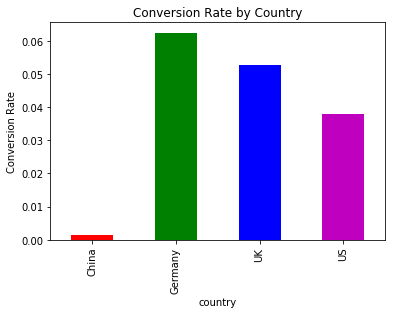

In [15]:
# 1. Conversion Rate by Country
CountryCon = ConData.groupby('country')['converted'].mean()
my_colors = 'rgbmkyc'
Country_VS = CountryCon.plot(kind = 'bar', color = my_colors, title = 'Conversion Rate by Country')
Country_VS.set_ylabel("Conversion Rate")

plt.show()

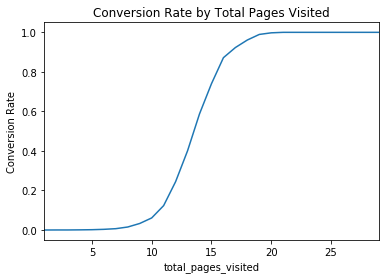

In [16]:
# 2. Conversion Rate by Total Pages Visited
CountryCon = ConData.groupby('total_pages_visited')['converted'].mean()
Country_VS = CountryCon.plot(kind = 'line', title = 'Conversion Rate by Total Pages Visited')
Country_VS.set_ylabel("Conversion Rate")
plt.show()

##### Observations:
1. Chinese conversion rate is much lower than other contries.
2. The more pages visted, the higher conversion rate. If a user visited more than 20 pages, the visitor have almost 100% probability to purchase.

# Part 3 Machine Learning
## Built a model to predict conversion rate

##### potential models for binary outcome:
1. Logistic Regression
2. Decision Trees
3. RuleFit (this is often your best choice)
4. Random Forest in combination with partial dependence plots

### Model 1: Random Forest

In [17]:
# shorter name, easier to plot
ConData.country.replace(['Germany', 'China'], ['DE', 'CN'], inplace = True)

# ???????????????? Not sure why the answer didn't encode country and source
# Encode category columns
ConData = pd.get_dummies(ConData)

# convert data to be category data type
ConData['new_user'] = ConData['new_user'].astype('category')           
ConData['converted'] = ConData['converted'].astype('category')



In [18]:
# split dataset into train data and test data
train, test = train_test_split(ConData, test_size=0.34)

x_train = train.loc[:, train.columns != 'converted'].copy()
y_train = train.loc[:, train.columns == 'converted'].copy()
x_test = train.loc[:, test.columns != 'converted'].copy()
y_test = train.loc[:, test.columns == 'converted'].copy()






In [19]:
# Train Model
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
# Predict Result
y_predict = clf.predict(x_test)
y_Predict_Proba = clf.predict_proba(x_test)

Confusion matrix, without normalization
[[201354    653]
 [  1777   4906]]
Normalized confusion matrix
[[ 0.9968  0.0032]
 [ 0.2659  0.7341]]


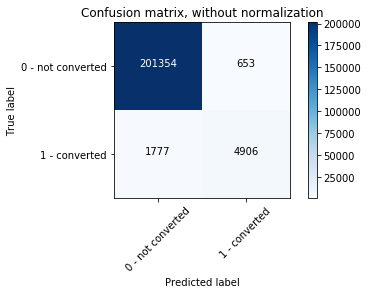

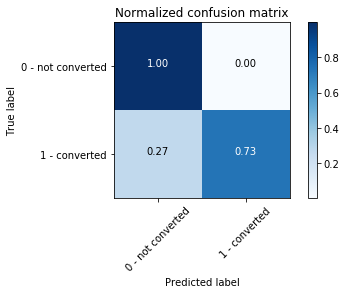

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0 - not converted', '1 - converted']



# Comput Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
ROC_score = auc(fpr, tpr)
print('ROC Score is: ', ROC_score)

ROC Score is:  0.865434445098


In [24]:
# Calculate feature importance
list(zip(x_test.columns, clf.feature_importances_))

[('age', 0.12160214401513228),
 ('new_user', 0.04247856436674062),
 ('total_pages_visited', 0.79154101700996038),
 ('country_CN', 0.019919414467531087),
 ('country_DE', 0.0031209101971822802),
 ('country_UK', 0.0047825003042219275),
 ('country_US', 0.0068962601672096831),
 ('source_Ads', 0.0031854915879645715),
 ('source_Direct', 0.0030009048872217557),
 ('source_Seo', 0.0034727929968355166)]